In [22]:
import os
import cv2
import numpy as np
import mediapipe as mp
import xml.etree.ElementTree as ET
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [14]:
from roboflow import Roboflow
rf =Roboflow(api_key='VuPyeUvBgaU9AJvZtnwp')
project=rf.workspace('sign-recognintion').project('sign-recoginition')

version=project.version(1)
dataset=version.download('voc')

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Sign-recoginition-1 in voc:: 100%|██████████| 9855/9855 [00:01<00:00, 9823.40it/s] 


# Intializing MediaPipe Setup

In [23]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2)

W0000 00:00:1746485823.491928     180 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1746485823.527099     180 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


# Paths and Variables

In [24]:
BASE_DIR = "/kaggle/working/Sign-recoginition-1"
SPLITS =  ['train', 'valid', 'test']
X, y = [], []

# Capturing Landmarks

In [25]:
def extract_landmarks(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = hands.process(img_rgb)
    if not result.multi_hand_landmarks:
        return None

    landmarks = []
    # first hand
    for lm in result.multi_hand_landmarks[0].landmark:
        landmarks.extend([lm.x, lm.y, lm.z])
        
    # second hand if it exists
    if len(result.multi_hand_landmarks) > 1:
        for lm in result.multi_hand_landmarks[1].landmark:
            landmarks.extend([lm.x, lm.y, lm.z])
    # if no 2nd hand, pad it with 0s
    else:
        landmarks.extend([0.0] * 63)

    return landmarks

# Fetching Labels from XML Files

In [27]:
def get_label_from_voc(xml_path):
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        name = root.find('object').find('name').text
        return name.strip()
    except:
        return None
        
'''
<annotation>
  <object>
    <name>yes</name>
    ...
'''

'\n<annotation>\n  <object>\n    <name>yes</name>\n    ...\n'

# Data Processing

In [28]:
for split in SPLITS:
    image_dir = os.path.join(BASE_DIR, split)
    
    for file in tqdm(os.listdir(image_dir)):
        if not file.endswith(".xml"):
            continue

        xml_path = os.path.join(image_dir, file)
        img_file = file.replace(".xml", ".jpg")
        img_path = os.path.join(image_dir, img_file)

        if not os.path.exists(img_path):
            continue

        landmarks = extract_landmarks(img_path)
        if landmarks is None:
            continue

        label = get_label_from_voc(xml_path)
        if label is None:
            continue

        X.append(landmarks)
        y.append(label)

100%|██████████| 444/444 [00:07<00:00, 60.91it/s]


In [29]:
X = np.array(X)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

In [48]:
np.save("/kaggle/working/X.npy", X)
np.save("/kaggle/working/y.npy", y_cat)
np.save("/kaggle/working/labels.npy", le.classes_)

X = np.load("/kaggle/working/X.npy")
y = np.load("/kaggle/working/y.npy")

In [51]:
X = X / np.max(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
print(le.classes_)
classes = len(le.classes_)
print(classes)

['1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'ExcuseMe' 'F'
 'Food' 'G' 'H' 'Hello' 'Help' 'House' 'I' 'I Love You' 'Internet' 'J' 'K'
 'L' 'M' 'N' 'No' 'O' 'P' 'Please' 'Q' 'R' 'S' 'T' 'ThankYou' 'U' 'V' 'W'
 'X' 'Y' 'Yes' 'Z']
46


# Preperation for the model

In [40]:
import tensorflow as tf
cp = tf.keras.callbacks.ModelCheckpoint(
    "/kaggle/working/best_model.keras", 
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    patience=5, 
    restore_best_weights=True,
    verbose=1
)

lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=3, 
    verbose=1
)
callbacks = [cp,es,lr]

# Model Architecture

In [46]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(126,)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 256)                 │          32,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 46)                  │           5,934 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,342 (278.68 KB)

 Trainable params: 71,342 (278.68 KB)

 Non-trainable params: 0 (0.00 B)

# Training

In [52]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, callbacks=callbacks)

Epoch 1/20


I0000 00:00:1746489360.568067     230 service.cc:148] XLA service 0x7ee438005b90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746489360.569396     230 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746489360.569416     230 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746489361.094566     230 cuda_dnn.cc:529] Loaded cuDNN version 90300


 77/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0576 - loss: 3.6463

I0000 00:00:1746489362.913214     230 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0715 - loss: 3.5652
Epoch 1: val_accuracy improved from -inf to 0.41243, saving model to /kaggle/working/best_model.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.0720 - loss: 3.5630 - val_accuracy: 0.4124 - val_loss: 2.5900 - learning_rate: 0.0010
Epoch 2/20
 80/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3123 - loss: 2.5698
Epoch 2: val_accuracy improved from 0.41243 to 0.70395, saving model to /kaggle/working/best_model.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3319 - loss: 2.4963 - val_accuracy: 0.7040 - val_loss: 1.4654 - learning_rate: 0.0010
Epoch 3/20
 82/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5445 - loss: 1.6540
Epoch 3: val_accuracy improved from 0.70395 to 0.79661, saving model to /kaggle/working/best_model.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5523 - loss: 1.6200 - val_accuracy: 0.7966 - val_loss: 0.9564 - learning_rate: 0.0010
Epoch 4/20
 85/1

# Visualizing Learning Curves

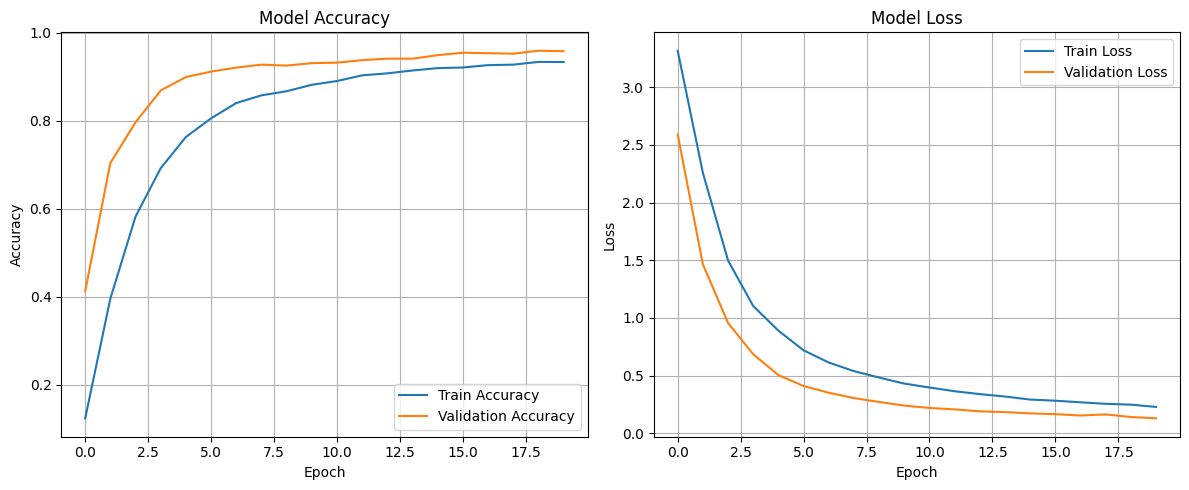

In [55]:
# Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluating the Model

In [54]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {loss:.4f}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9597 - loss: 0.1431 
Test Accuracy: 95.93%
Test Loss: 0.1420


# Model Prediction

In [59]:
def predict_image(image_path):
    landmarks = extract_landmarks(image_path)
    if landmarks is None:
        print("❌ No hands detected.")
        return

    # Normalize and reshape
    X_input = np.array(landmarks).reshape(1, -1)
    X_input = X_input / np.max(X)

    # Predict
    y_pred = model.predict(X_input)
    class_index = np.argmax(y_pred)
    class_label = le.inverse_transform([class_index])[0]

    print(f"✅ Predicted Label: {class_label}")

In [63]:
predict_image('/kaggle/input/test-img/ily.webp')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
✅ Predicted Label: I Love You


# Saving the Model

In [56]:
model.save("/kaggle/working/sign_fcn_model.h5")

In [58]:
import pickle
with open("/kaggle/working/label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)